In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [219]:
def make_vertices(n, seed=None):
    if seed is not None:
        np.random.seed(seed)
    thetas = np.random.uniform(size=n)*0.5*np.pi
    thetas = np.sort(thetas)
    X = np.array([0, *np.cos(thetas)])
    Y = np.array([0, *np.sin(thetas)])
    return X, Y

def vertices_to_inequalities(X, Y):
    A = []
    B = []
    C = []
    n = len(X)
    for i in range(n):
        x1, y1 = X[i], Y[i]
        x2, y2 = (X[i+1], Y[i+1]) if i < n - 1 else (X[0], Y[0])
        a, b = (y2 - y1), -(x2 - x1)
        c = a*x1 + b*y1
        A.append(a)
        B.append(b)
        C.append(c)
        assert np.isclose(a*x1 + b*y1, c), i
        assert np.isclose(a*x2 + b*y2, c), i
        assert a*np.mean(X) + b*np.mean(Y) < c, i
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)
    return A, B, C

def check(X, Y, A, B, C):
    XX = []
    YY = []
    n = len(X)
    for i in range(n - 1):
        for j in range(i + 1, n):
            U = np.array([[A[i], B[i]], [A[j], B[j]]])
            v = np.array([C[i], C[j]])
            x, y = np.linalg.solve(U, v)
            if np.all(np.logical_or(np.isclose(A*x + B*y, C), A*x + B*y < C)):
                XX.append(x)
                YY.append(y)
    XX = np.array(XX)
    YY = np.array(YY)
    I = np.argsort(np.arctan2(YY, XX))
    XX = XX[I]
    YY = YY[I]
    return np.allclose(X, XX) and np.allclose(Y, YY)

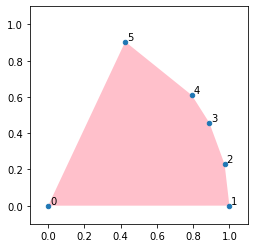

In [242]:
X, Y = make_vertices(5, seed=1)
A, B, C = vertices_to_inequalities(X, Y)
check(X, Y, A, B, C)

ax = plt.gca()
ax.set_aspect("equal")
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.scatter(X, Y, s=20)
for i, (x, y) in enumerate(zip(X, Y)):
    ax.annotate(str(i), (x + 0.01, y + 0.01))
ax.fill(X, Y, "pink", zorder=-1)

plt.show()

In [243]:
k = len(X)//2
I = np.isclose(A*X[k] + B*Y[k], C)
assert np.sum(I) == 2
u = -A[I].sum()
v = -B[I].sum()
assert np.argmin(u*X + v*Y) == k

In [332]:
def make_vs(n, seed=None, min_ang_sep=0.1):
    if seed is not None:
        np.random.seed(seed)
    while True:
        theta = np.sort([0, *np.random.uniform(size=n)*0.5*np.pi, 0.5*np.pi])
        if np.alltrue(np.diff(theta) > min_ang_sep):
            break

    X = np.array([np.cos(theta), np.sin(theta)]).T
    assert np.all(np.diff(X[:,0]) < 0)
    assert np.all(np.diff(X[:,1]) > 0)
    return X

def vs_to_is(X):
    m = len(X) - 1
    A = np.zeros((m, 2))
    b = np.zeros(m)
    for i in range(m):
        v = X[i + 1] - X[i]
        A[i] = [v[1], -v[0]]
        b[i] = A[i].dot(X[i])
        assert np.isclose(A[i].dot(X[i + 1]), b[i])
    
    assert np.alltrue(b > 0) # (0, 0) is feasible

    for i in range(m - 1):
        x = np.linalg.solve(A[i:i + 2], b[i:i + 2])
        assert np.allclose(x, X[i + 1])
        
    return A, b

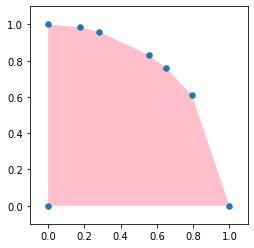

In [411]:
m = 6
X = make_vs(m - 1, seed=666)
A, b = vs_to_is(X)

x = [0, *X[:,0]]
y = [0, *X[:,1]]
ax = plt.gca()
ax.set_aspect("equal")
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.scatter(x, y, s=30)
ax.fill(x, y, "pink", zorder=-1)

plt.show()

In [416]:
def get_adjacent_vertices(x, A, b):
    m, n = A.shape
    AI = np.hstack([A, np.identity(m)])
    N = set([i for i in range(n + m) if x[i] == 0])
    B = set([i for i in range(n + m) if x[i] != 0])
    V = []
    for e in N:
        for l in B:
            BB = B.copy()
            NN = N.copy()
            BB.remove(l)
            BB.add(e)
            BB = list(BB)
            NN.remove(e)
            NN.add(l)
            NN = list(NN)
            xx = np.zeros_like(x)
            xx[BB] = np.linalg.solve(AI[:, BB], b)
            if np.alltrue(xx >= 0):
                V.append(xx)
    return np.array(V)

In [417]:
c = -X[len(X)//2]
m, n = A.shape
x = np.concatenate([np.zeros(n), b])
c = np.concatenate([-X[len(X)//2], np.zeros(m)])
while True:
    V = get_adjacent_vertices(x, A, b)
    i = np.argmin(V @ c)
    v = V[i]
    if v @ c < x @ c:
        x = v
        print(x[:n], x @ c)
    else:
        break

[0. 1.] -0.8326933009470039
[0.17363205 0.9848106 ] -0.9161912386302691
[0.28068962 0.95979859] -0.9546453774638768
[0.55373447 0.8326933 ] -0.9999999999999998
